File che riassume i risultati del modello Linknet sul dataset aumentato usando come backbone resnet34 e immagini di dimensioni 128x128

In [15]:
# importing required packages...
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.utils import normalize
from tensorflow import keras
from keras.utils import to_categorical
import random
import segmentation_models as sm #pip install segmentation_models
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from tensorflow.keras import layers
import pickle
from typing import Tuple

In [16]:
def resize_with_pad(image: np.array, 
                    new_shape: Tuple[int, int], 
                    padding_color: Tuple[int] = (0,0,0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [17]:

# loading image data...
def image_loader(folder_dir,sx,sy):
    image_dataset = []
    for images in os.listdir(folder_dir):
        path = os.path.join(folder_dir,images)
        image = cv2.imread(path)
        image = resize_with_pad(image, (sx, sy)) #Mantengo la giusta proporzione e aggiungo del padding
        image_dataset.append(image)
    return image_dataset

In [18]:
# loading mask data...
def mask_loader(folder_dir,sx,sy):
    image_dataset = []
    for images in os.listdir(folder_dir):
        path = os.path.join(folder_dir,images)
        image = cv2.imread(path, 0)
        image = resize_with_pad(image, (sx, sy))
        image_dataset.append(image)
    return image_dataset

In [19]:
parent = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) #parent directory
img_folder = os.path.join("..", "car-segmentation", "images")
masks_folder = os.path.join("..", "car-segmentation", "masks")
n_classes = 5 # class for segmentation
size_x = 128
size_y = 128

image_dataset = image_loader(img_folder,size_x,size_y) # real images...
mask_dataset = mask_loader(masks_folder,size_x,size_y) # masked images...
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
#Espando la dimensione anche della maschera
mask_dataset_encoded = np.expand_dims(mask_dataset, axis = 3)

#Normalize images (pixel diventano tra 0 e 1)
#image_dataset = image_dataset /255. 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

In [20]:
#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
print("image Shape:")   
print(X_train.shape)
print(X_test.shape)
print("mask shape:")
print(y_train.shape)
print(y_test.shape)
print(f"Dimensione training set: {len(X_train)}\nDimensione val set: {len(X_val)}\nDimensione test set: {len(X_test)}")
     

image Shape:
(1080, 128, 128, 3)
(338, 128, 128, 3)
mask shape:
(1080, 128, 128, 1)
(338, 128, 128, 1)
Dimensione training set: 1080
Dimensione val set: 270
Dimensione test set: 338


In [21]:
#Le maschere devono avere il formato dell'ultimo layer del modello (128x128x5)
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

val_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))


In [22]:
#Preparo il modello
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
# preprocess input
X_train_pro = preprocess_input(X_train)
X_val_pro = preprocess_input(X_val)
X_test_pro = preprocess_input(X_test)

In [23]:

#Load previously saved model
from keras.models import load_model
path = os.path.join("..", "LinkNet_128x128.hdf5")
loss = sm.losses.bce_jaccard_loss
model = load_model(path,custom_objects={'binary_crossentropy_plus_jaccard_loss': loss,'iou_score': sm.metrics.iou_score, 'f1-score':sm.metrics.FScore(threshold=0.5)}) 
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 128, 128, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']   

Accuracy ottenuta 0.9888688921928406, Loss ottenuta: 0.1340313702821731
Val accuracy: 0.9810212254524232, Val loss: 0.2056658267974853
IOU Score ottenuto 0.8808436393737793, Val IOU Score: 0.8226494193077087
F-Score: 0.934043824672699, Val F-score: 0.8938111066818237


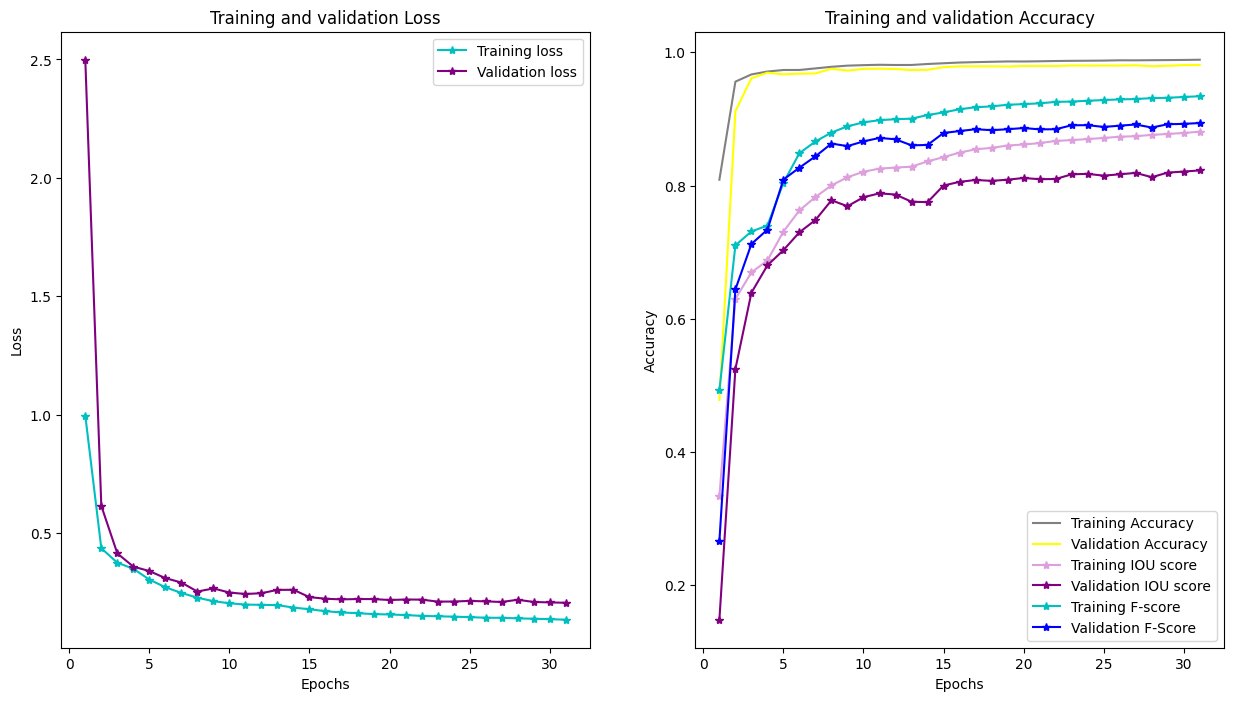

In [24]:
import pandas as pd

log_data = pd.read_csv('LinkNet_128x128.log', sep=',', engine='python')
patience = 5

#plot the training and validation accuracy and loss at each epoch
loss = log_data['loss'].iloc[:-patience]
val_loss = log_data['val_loss'].iloc[:-patience]
epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 2, 1)
plt.plot(epochs, loss, 'c', marker="*", label='Training loss')
plt.plot(epochs, val_loss, 'purple', marker="*", label='Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


acc = log_data['accuracy'].iloc[:-patience]
val_acc = log_data['val_accuracy'].iloc[:-patience]
iou = log_data['iou_score'].iloc[:-patience]
val_iou = log_data['val_iou_score'].iloc[:-patience]
fscore = log_data['f1-score'].iloc[:-patience]
val_fscore = log_data['val_f1-score'].iloc[:-patience]
ax = fig.add_subplot(1, 2, 2)
plt.plot(epochs, acc, 'gray',   label='Training Accuracy')
plt.plot(epochs, val_acc, 'yellow',  label='Validation Accuracy')
plt.plot(epochs, iou, 'plum',  marker="*", label='Training IOU score')
plt.plot(epochs, val_iou, 'purple', marker="*", label='Validation IOU score')
plt.plot(epochs, fscore, 'c',  marker="*", label='Training F-score')
plt.plot(epochs, val_fscore, 'blue', marker="*", label='Validation F-Score')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
print(f"Accuracy ottenuta {acc.iloc[-1]}, Loss ottenuta: {loss.iloc[-1]}\nVal accuracy: {val_acc.iloc[-1]}, Val loss: {val_loss.iloc[-1]}")
print(f"IOU Score ottenuto {iou.iloc[-1]}, Val IOU Score: {val_iou.iloc[-1]}\nF-Score: {fscore.iloc[-1]}, Val F-score: {val_fscore.iloc[-1]}")

In [25]:
from keras import backend as K
K.clear_session()

#Predizione del modello sul dataset test
y_pred=model.predict(X_test_pro)
#Argmax controlla il valore maggiore dell'asse indicato e prende solo quello
y_pred_argmax=np.argmax(y_pred, axis=3)


11/11 [==============================] - 17s 1s/step


In [26]:
#Controllo effettivamente il modello sul validation set
val_res = model.evaluate(X_val_pro,y_val_cat)
print(f"Loss ottenuta sul test: {val_res[0]}\tAccuracy ottenuta sul test: {val_res[3]}")
print(f"IOUscore ottenuto sul test: {val_res[1]}\tF-Score ottenuto sul test: {val_res[2]}")

#Controllo i risultati sul test set
results = model.evaluate(X_test_pro, y_test_cat)
print(f"Loss ottenuta sul test: {results[0]}\tAccuracy ottenuta sul test: {results[3]}")
print(f"IOUscore ottenuto sul test: {results[1]}\tF-Score ottenuto sul test: {results[2]}")


9/9 [==============================] - 13s 1s/step - loss: 0.2056 - iou_score: 0.8228 - f1-score: 0.8941 - accuracy: 0.9810
Loss ottenuta sul test: 0.20561879873275757	Accuracy ottenuta sul test: 0.9810212254524231
IOUscore ottenuto sul test: 0.8227779865264893	F-Score ottenuto sul test: 0.8940690159797668
11/11 [==============================] - 14s 1s/step - loss: 0.2087 - iou_score: 0.8202 - f1-score: 0.8922 - accuracy: 0.9802
Loss ottenuta sul test: 0.20871971547603607	Accuracy ottenuta sul test: 0.98016756772995
IOUscore ottenuto sul test: 0.8202428221702576	F-Score ottenuto sul test: 0.8921688199043274


In [27]:
#Per vedere un'unica classe alla volta -> y_pred[n_image][:,:,classe]
classi = ['background', 'car', 'wheel', 'lights', 'windows']
#Using built in keras function
from keras.metrics import MeanIoU
#n_classes = 5
#IOU_keras = MeanIoU(num_classes=n_classes)  
#IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
#print("Mean IoU =", IOU_keras.result().numpy())
#si può calcolare la mean IoU per ogni classe
# target_class_ids indicates the class/classes you want to calculate IoU on
for i in range(5):
    loss = tf.keras.metrics.IoU(num_classes=5, target_class_ids=[i])
    loss.update_state(y_test, y_pred_argmax)
    print("Risultato per la classe", classi[i] ,": ",loss.result().numpy())

Risultato per la classe background :  0.98667514
Risultato per la classe car :  0.90146667
Risultato per la classe wheel :  0.90026367
Risultato per la classe lights :  0.5153791
Risultato per la classe windows :  0.8176345


1/1 [==============================] - 0s 88ms/step


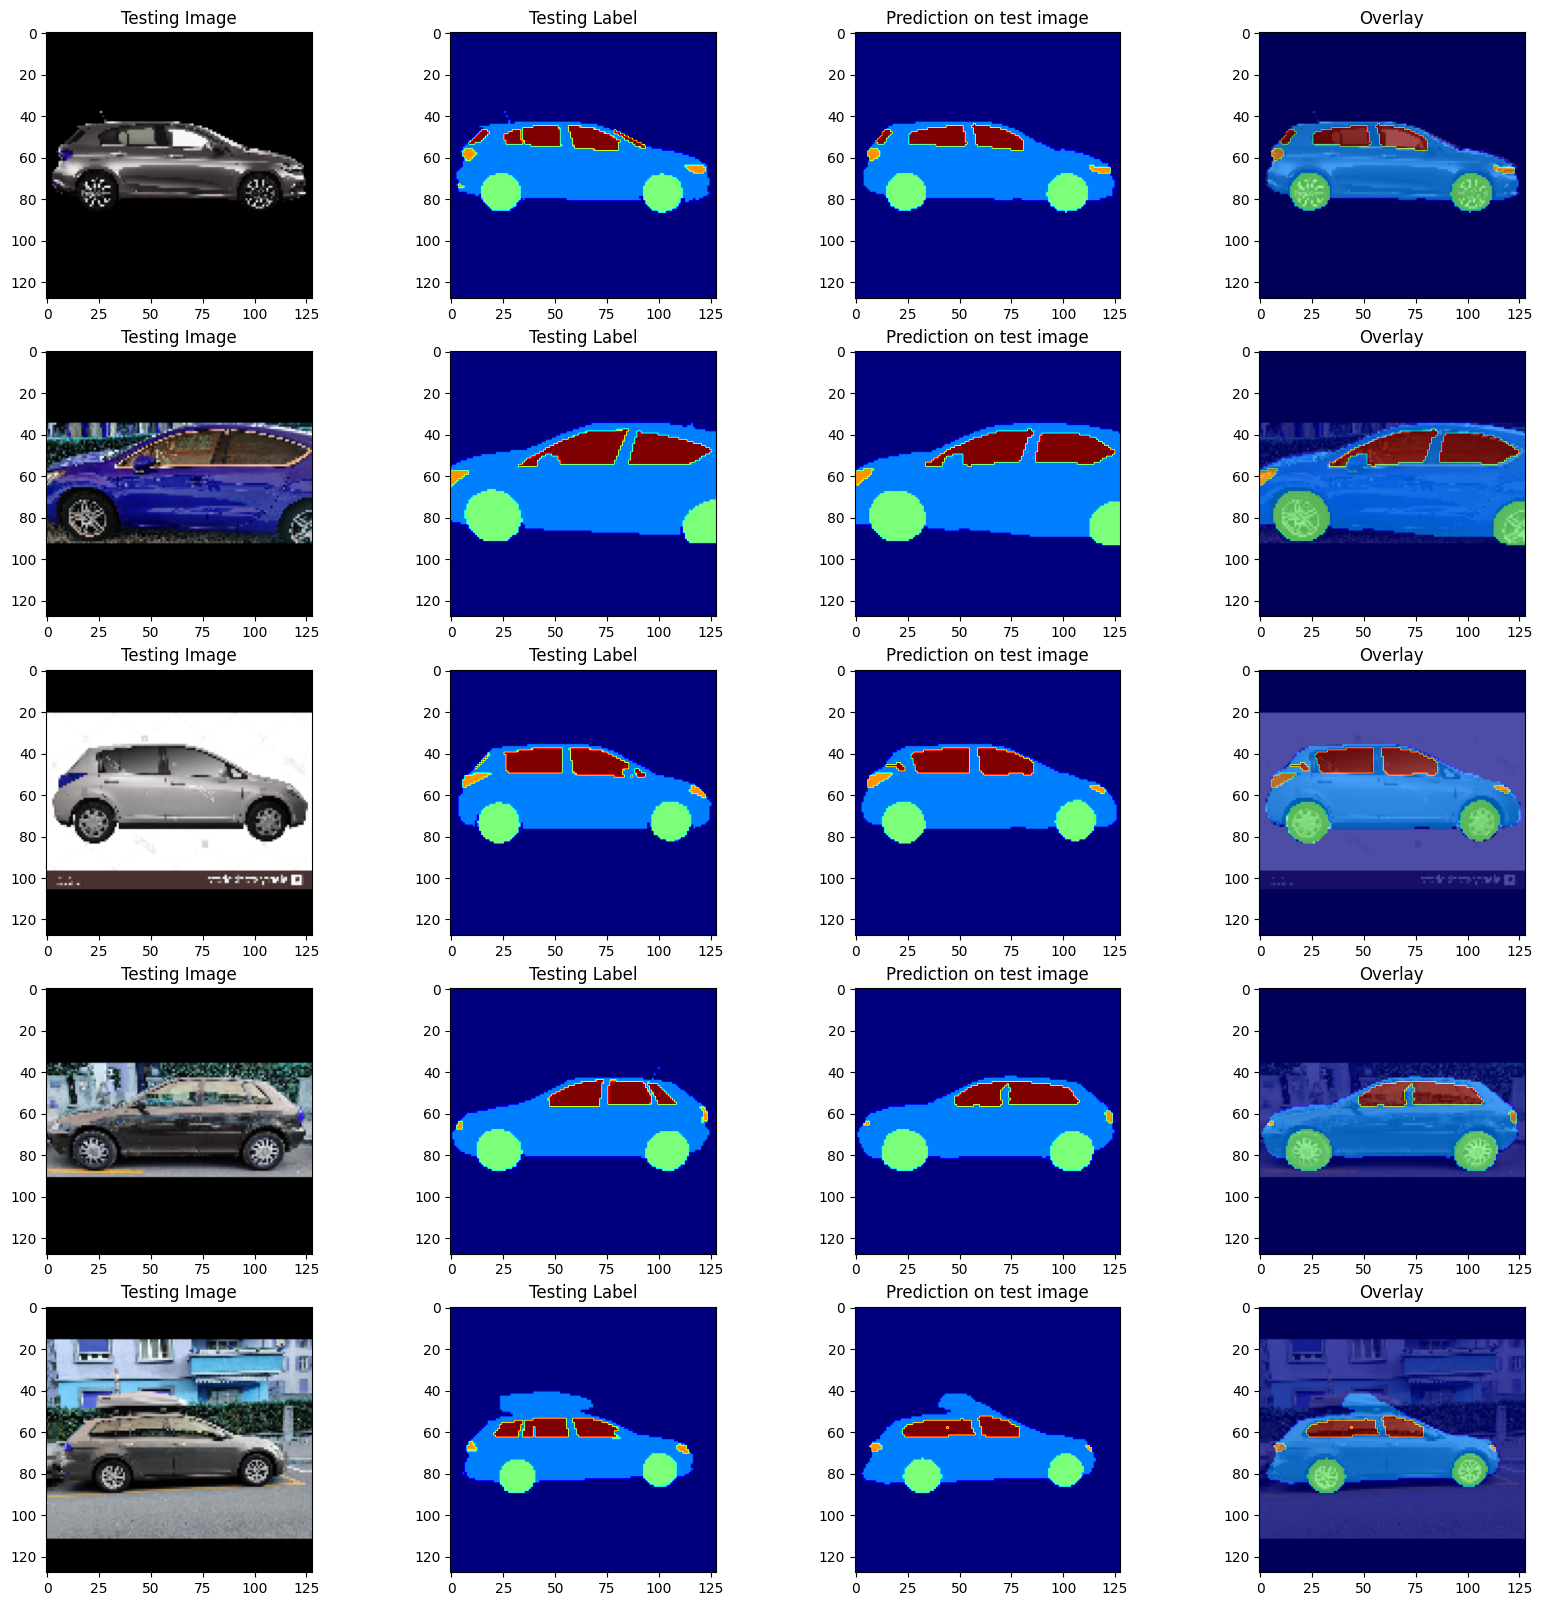

In [28]:
import random

fig = plt.figure(figsize=(20, 20))

for i in range(5):
    number = random.randint(0, len(X_test)-1)
    #Seleziono un'immagine da mostrare
    img = X_test[number]
    #Seleziono la sua maschera
    ground_truth=y_test[number]
    
    #Predico la maschera
    test_img = X_test_pro[number]
    test_img_input = np.expand_dims(test_img,0)
    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:] #passo da (1,128,128,5) a (128,128)

    ax = fig.add_subplot(5,4,i*4+1)
    plt.title('Testing Image')
    plt.imshow(img)
    
    ax = fig.add_subplot(5,4,i*4+2)
    plt.title('Testing Label')
    plt.imshow(ground_truth, cmap='jet')
    
    ax = fig.add_subplot(5,4,i*4+3)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img, cmap='jet')
    
    ax = fig.add_subplot(5,4,i*4+4)
    plt.title('Overlay')
    plt.imshow(img)
    plt.imshow(predicted_img, cmap='jet', alpha=0.7)
   